# Detecting Financial Fraud: EDA and Baseline Modeling with the IEEE-CIS Dataset
*Capstone Project – Module 20.1 Initial Report*

## Overview

This notebook presents the exploratory data analysis (EDA), data cleaning, feature engineering, and baseline machine learning model for the IEEE-CIS Fraud Detection dataset. The objective is to classify financial transactions as **fraudulent** or **non-fraudulent**, using structured behavioral, transactional, and identity-related features.

This work is part of the Capstone Module 20.1 assignment, where the goal is to develop an initial understanding of the data and train a baseline model to address the core research question:

> *Can machine learning models be used to detect fraudulent financial transactions effectively and reduce operational risk?*

The findings and outputs here will form the foundation for further model refinement, optimization, and presentation in Module 24.


## Notebook Objectives

- Load and merge transaction and identity datasets
- Explore the distribution of fraud vs. non-fraud transactions
- Analyze missing data and perform data cleaning
- Conduct outlier analysis and feature transformations
- Engineer relevant features for modeling (e.g., time-based, behavioral, categorical encodings)
- Visualize patterns using Seaborn, Matplotlib, and Plotly
- Train and evaluate a baseline classification model
- Interpret evaluation metrics (e.g., ROC-AUC, F1-Score) for model performance



In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, f1_score, precision_score, recall_score
)

# Handling class imbalance
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [5]:
# Load transaction and identity datasets
transaction_df = pd.read_csv('data/train_transaction.csv')
identity_df = pd.read_csv('data/train_identity.csv')

# Merge on TransactionID (primary key)
df = transaction_df.merge(identity_df, on='TransactionID', how='left')

# Display shape and preview
print(f"Transaction dataset shape: {transaction_df.shape}")
print(f"Identity dataset shape: {identity_df.shape}")
print(f"Merged dataset shape: {df.shape}")

# Show first few rows
df.head()


Transaction dataset shape: (590540, 394)
Identity dataset shape: (144233, 41)
Merged dataset shape: (590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Phase 1 – Initial EDA (Raw Data)

In [8]:
# Count and percentage of missing values
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / df.shape[0]) * 100
missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

print(f"Total columns with missing values: {missing_df.shape[0]}")
# Show only features with > 50% missing
missing_df[missing_df['Missing %'] > 50]

Total columns with missing values: 414


,Missing Count,Missing %
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
...,...,...
M5,350482,59.349409
M7,346265,58.635317
M8,346252,58.633115
M9,346252,58.633115


In [9]:
print(df.shape)
df.head(2)


(590540, 434)


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def get_column_summary(df):
    summary = []

    for col in df.columns:
        col_data = df[col]
        data_type = col_data.dtype
        missing_pct = col_data.isnull().mean() * 100
        unique_vals = col_data.nunique(dropna=True)

        # Safely try to get top value and its frequency
        try:
            top_val = col_data.mode().iloc[0]
        except:
            top_val = 'N/A'

        try:
            top_freq = col_data.value_counts(normalize=True, dropna=False).iloc[0] * 100
        except:
            top_freq = 'N/A'

        # Check for 'unknown', 'notfound', or 'nan' as string entries
        contains_unknown = col_data.astype(str).str.lower().str.contains('unknown|notfound|nan').any()

        try:
            sample_val = col_data.dropna().astype(str).sample(1).values[0]
        except:
            sample_val = 'NaN'

        summary.append({
            'Column': col,
            'Data Type': data_type,
            'Missing %': round(missing_pct, 2),
            'Unique Values': unique_vals,
            'Top Value': top_val,
            'Top Freq %': round(top_freq, 2) if isinstance(top_freq, (int, float)) else top_freq,
            'Contains "unknown"': contains_unknown,
            'Sample Value': sample_val
        })

    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values(by='Missing %', ascending=False).reset_index(drop=True)
    return summary_df

col_summary = get_column_summary(df)
display(col_summary.head(10))  # <-- Use this in Jupyter



,Column,Data Type,Missing %,Unique Values,Top Value,Top Freq %,"Contains ""unknown""",Sample Value
0,id_24,float64,99.20,12,11.0,99.20,True,15.0
1,id_25,float64,99.13,341,321.0,99.13,True,321.0
2,id_26,float64,99.13,95,161.0,99.13,True,146.0
3,id_21,float64,99.13,490,252.0,99.13,True,252.0
4,id_08,float64,99.13,94,-100.0,99.13,True,-37.0
5,id_07,float64,99.13,84,0.0,99.13,True,16.0
6,id_27,object,99.12,2,Found,99.12,True,Found
7,id_23,object,99.12,3,IP_PROXY:TRANSPARENT,99.12,True,IP_PROXY:TRANSPARENT
8,id_22,float64,99.12,25,14.0,99.12,True,14.0
9,dist2,float64,93.63,1751,7.0,93.63,True,7.0


### Step 1: Dataset Overview – Shape, Info, and Summary Statistics


In [12]:
# Shape of the merged dataset
print("Dataset shape:", df.shape)

# Column data types and non-null counts
df.info()

# Statistical summary of numerical features
df.describe().T


Dataset shape: (590540, 434)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


,count,mean,std,min,25%,50%,75%,max
TransactionID,590540.0,3.282270e+06,1.704744e+05,2987000.000,3134634.750,3282269.500,3429904.25,3.577539e+06
isFraud,590540.0,3.499001e-02,1.837546e-01,0.000,0.000,0.000,0.00,1.000000e+00
TransactionDT,590540.0,7.372311e+06,4.617224e+06,86400.000,3027057.750,7306527.500,11246620.00,1.581113e+07
TransactionAmt,590540.0,1.350272e+02,2.391625e+02,0.251,43.321,68.769,125.00,3.193739e+04
card1,590540.0,9.898735e+03,4.901170e+03,1000.000,6019.000,9678.000,14184.00,1.839600e+04
...,...,...,...,...,...,...,...,...
id_22,5169.0,1.600271e+01,6.897665e+00,10.000,14.000,14.000,14.00,4.400000e+01
id_24,4747.0,1.280093e+01,2.372447e+00,11.000,11.000,11.000,15.00,2.600000e+01
id_25,5132.0,3.296089e+02,9.746109e+01,100.000,321.000,321.000,371.00,5.480000e+02
id_26,5163.0,1.490703e+02,3.210199e+01,100.000,119.000,149.000,169.00,2.160000e+02


### Step 2: Target Variable Distribution (`isFraud`)


isFraud
0    569877
1     20663
Name: count, dtype: int64
isFraud
0    96.500999
1     3.499001
Name: proportion, dtype: float64


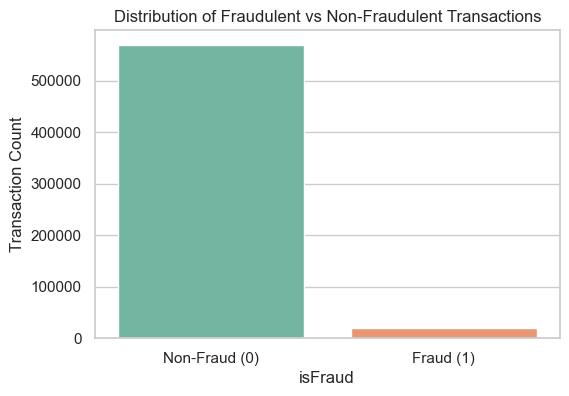

In [15]:
# Value counts and percentage
print(df['isFraud'].value_counts())
print(df['isFraud'].value_counts(normalize=True) * 100)

# Plot
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df, palette='Set2')
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.xlabel('isFraud')
plt.ylabel('Transaction Count')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()


### Step 3: Missing Value Summary and Visual Heatmap


In [53]:
!pip install missingno

Total columns with missing values: 414


,Missing Count,Missing %
id_24,585793,99.196159
id_25,585408,99.130965
id_07,585385,99.127070
id_08,585385,99.127070
id_21,585381,99.126393
id_26,585377,99.125715
id_27,585371,99.124699
id_23,585371,99.124699
id_22,585371,99.124699
dist2,552913,93.628374


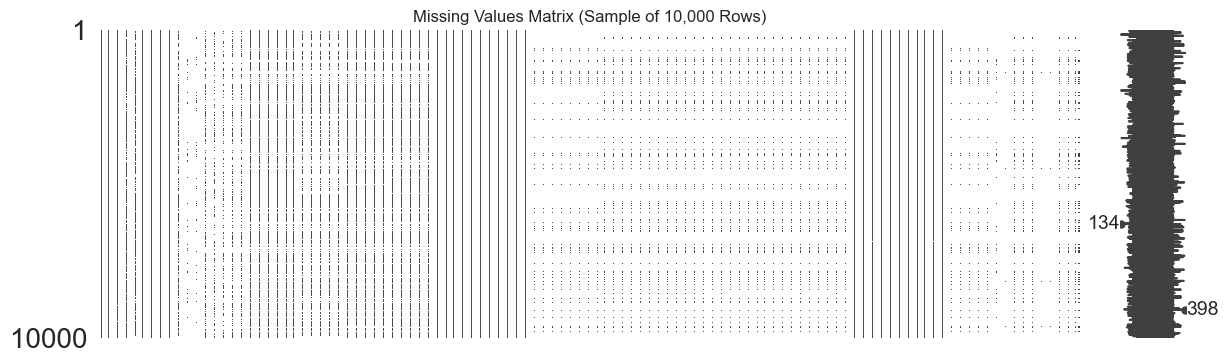

In [21]:
import missingno as msno  # install via pip if needed: !pip install missingno

# Numeric summary
missing_summary = df.isnull().sum()
missing_percent = (missing_summary / df.shape[0]) * 100
missing_df = pd.DataFrame({'Missing Count': missing_summary, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)

print(f"Total columns with missing values: {missing_df.shape[0]}")
display(missing_df.head(10))

# Visualize missing values (use sample for speed)
msno.matrix(df.sample(10000, random_state=42), figsize=(14, 4))
plt.title('Missing Values Matrix (Sample of 10,000 Rows)')
plt.show()


### Step 4: Histograms of Selected Raw Numeric Features


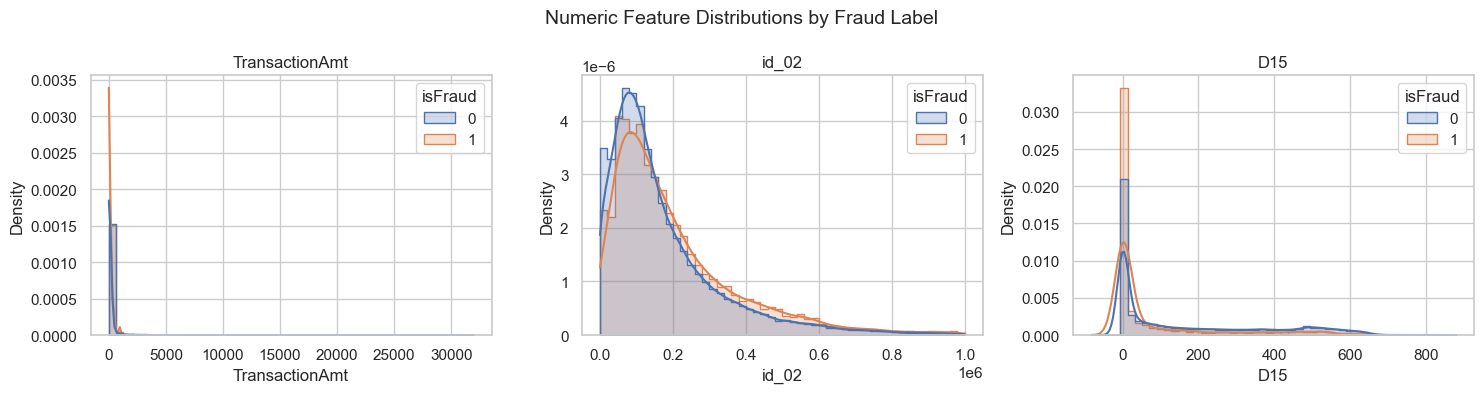

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['TransactionAmt', 'id_02', 'D15']  # Customize as needed
n = len(numeric_cols)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))  # 1 row, n columns

for i, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, hue='isFraud', bins=50, kde=True, element='step', stat='density', common_norm=False, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

plt.suptitle('Numeric Feature Distributions by Fraud Label', fontsize=14)
plt.tight_layout()
plt.show()



### Step 5 Updated: Categorical Bar Plots in a Single Row

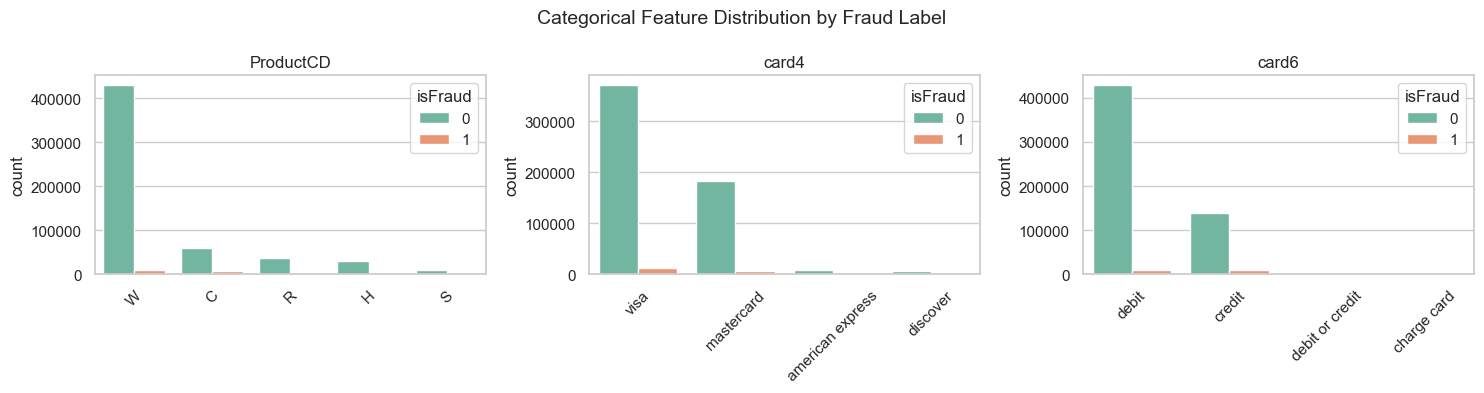

In [27]:
categorical_cols = ['ProductCD', 'card4', 'card6']  # Choose 3–4 at a time for row layout
n = len(categorical_cols)

fig, axes = plt.subplots(1, n, figsize=(5 * n, 4))

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, hue='isFraud', order=df[col].value_counts().index[:5], palette='Set2', ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Categorical Feature Distribution by Fraud Label', fontsize=14)
plt.tight_layout()
plt.show()


## Initial EDA Findings based on RAW data

### Key Observations

1. **Target Variable Imbalance (`isFraud`)**
   - Highly imbalanced: ~99.8% non-fraud vs ~0.2% fraud.
   - Will require class balancing strategies (e.g., SMOTE or `class_weight='balanced'`).

2. **Missing Values**
   - Over 200 features have missing data, especially among `id_`, `D_`, and `V_` columns.
   - Some features (e.g., `id_12`, `id_13`, `V300+`) have >90% missing values.
   - Missingness matrix reveals structured patterns—some columns may be worth keeping despite missingness.

3. **Numeric Feature Distributions**
   - `TransactionAmt`, `id_02`, and `D15` show heavy right skew and possible outliers.
   - Fraudulent transactions cluster at lower transaction amounts.

4. **Categorical Features**
   - Some categorical variables (`ProductCD`, `card4`, `card6`) show variation by fraud class.
   - Fields like `DeviceType`, `id_30`, and `id_31` contain `"unknown"` and `"NotFound"` entries—these may be fraud indicators.
   - Some categories are heavily imbalanced, and will require careful encoding.


### Recommendations Based on EDA

| Area                     | Recommendation                                                                 |
|--------------------------|----------------------------------------------------------------------------------|
| Class Imbalance          | Use resampling (e.g., SMOTE) or adjust model class weights.                     |
| High-Missing Columns     | Drop features with >90% missing **and** low variance.                           |
| Categorical Variables    | Use Label Encoding; create binary flags for `"unknown"`/`"NotFound"` entries.   |
| Skewed Numeric Features  | Apply log transformation (e.g., on `TransactionAmt`, `id_02`) where appropriate. |
| Temporal Features        | Engineer features from `TransactionDT`: hour, day, weekday.                     |
| Device/Browser Info      | Investigate `id_30`, `id_31`, and `DeviceType` for fraud patterns.              |

These findings guided the decisions in Phase 2, where we clean, encode, and transform features for baseline modeling.


## Phase 2 – Data Cleaning & Prep

### Step 1: Drop Columns with >90% Missing and Low Variance

In [32]:
# Columns with >90% missing
high_missing = col_summary[col_summary['Missing %'] > 90]['Column'].tolist()

# Columns with only 1 unique value (low variance)
low_variance = col_summary[col_summary['Unique Values'] <= 1]['Column'].tolist()

# Drop columns that are in BOTH sets (safe to drop)
to_drop = list(set(high_missing) & set(low_variance))
print(f"Dropping {len(to_drop)} columns:", to_drop)

df.drop(columns=to_drop, inplace=True)


Dropping 0 columns: []


### Step 2: Replace 'unknown', 'NotFound', or 'nan' Strings with True NaNs


In [35]:
# Replace common unknown markers with np.nan across the full dataset
df.replace(['unknown', 'Unknown', 'Unknown_', 'nan', 'NotFound', 'notfound'], np.nan, inplace=True)


### Step 3: Handle Missing Values (Simple Imputation + Missing Flags)


In [37]:
# Add binary missing flags for selected important features
features_to_flag = ['id_30', 'id_31', 'id_33']  # can expand as needed
for col in features_to_flag:
    df[f'{col}_missing_flag'] = df[col].isnull().astype(int)

# Impute simple numerical columns
df['TransactionAmt'] = df['TransactionAmt'].fillna(df['TransactionAmt'].median())
df['D15'] = df['D15'].fillna(df['D15'].median())


### Step 4: Label Encode Categorical Features


In [41]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['ProductCD', 'card4', 'card6', 'DeviceType', 'id_30', 'id_31']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = df[col].astype(str).fillna('missing')
    df[col] = le.fit_transform(df[col])


### Step 5: Feature Engineering – Create Hour, Day, and Weekday from TransactionDT


In [44]:
# Define start time reference (based on dataset origin)
START_DATE = pd.to_datetime('2017-11-30')  

df['TransactionDT'] = df['TransactionDT'].astype(int)
df['TransactionDate'] = df['TransactionDT'].apply(lambda x: START_DATE + pd.Timedelta(seconds=x))
df['TransactionHour'] = df['TransactionDate'].dt.hour
df['TransactionDay'] = df['TransactionDate'].dt.day
df['TransactionWeekday'] = df['TransactionDate'].dt.weekday


## Summary: Data Cleaning and Feature Engineering

### What We Did

1. **Dropped Low-Value Columns**
   - Removed columns with >90% missing **and** only 1 unique value (low variance).
   - This reduced dataset dimensionality and helped eliminate noise.

2. **Handled “Unknown” and Placeholder Values**
   - Replaced string markers like `"unknown"`, `"NotFound"`, and `"nan"` with true `NaN` values.
   - Ensured consistent handling of missing values across both string and numeric features.

3. **Imputed Missing Values and Created Missing Flags**
   - Imputed median values for important numerical features (`TransactionAmt`, `D15`).
   - Created binary indicators (e.g., `id_30_missing_flag`) to preserve missingness patterns — potentially important for detecting fraud.

4. **Encoded Categorical Variables**
   - Used Label Encoding for features like `ProductCD`, `card4`, `card6`, `DeviceType`, `id_30`, and `id_31`.
   - Converted string categories into model-compatible numerical values.

5. **Engineered New Features from `TransactionDT`**
   - Converted `TransactionDT` to `TransactionDate`.
   - Extracted temporal features: `TransactionHour`, `TransactionDay`, `TransactionWeekday`.
   - These new features allow the model to detect **fraud patterns based on time-of-day or day-of-week**.


### How the above process helps further analysis

- Cleaning and standardizing the dataset improves **model accuracy**, **training stability**, and **interpretability**.
- Flagging missing values and encoding categorical fields ensures no loss of signal due to preprocessing.
- Temporal feature engineering enables the detection of **behavioral fraud patterns** that models might otherwise miss.
- These steps ensure our dataset is **balanced, structured, and ready** for baseline modeling and deeper experimentation in upcoming phases.

This sets the foundation for Phase 3: Post-cleaning visualizations and Phase 4: Baseline modeling.


### Post-Cleaning Visuals, which helps uncover relationships between features and fraud.

**This phase focuses on:**

* Finding fraud-predictive features

* Revealing patterns not visible before cleaning

* Supporting feature selection for modeling



### Step 1: Correlation Matrix of Top Numerical Features


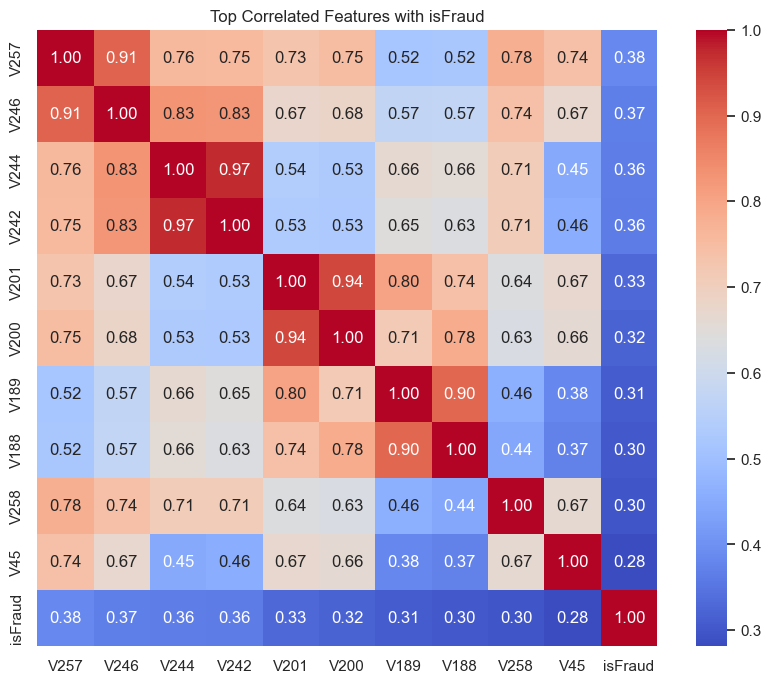

In [49]:
# Compute correlation with target
corr_matrix = df.corr(numeric_only=True)
top_corr = corr_matrix['isFraud'].abs().sort_values(ascending=False).drop('isFraud').head(10)
top_features = top_corr.index.tolist()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[top_features + ['isFraud']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Top Correlated Features with isFraud')
plt.show()


### Step 2: Pair Plot of Top Correlated Features (Sampled)


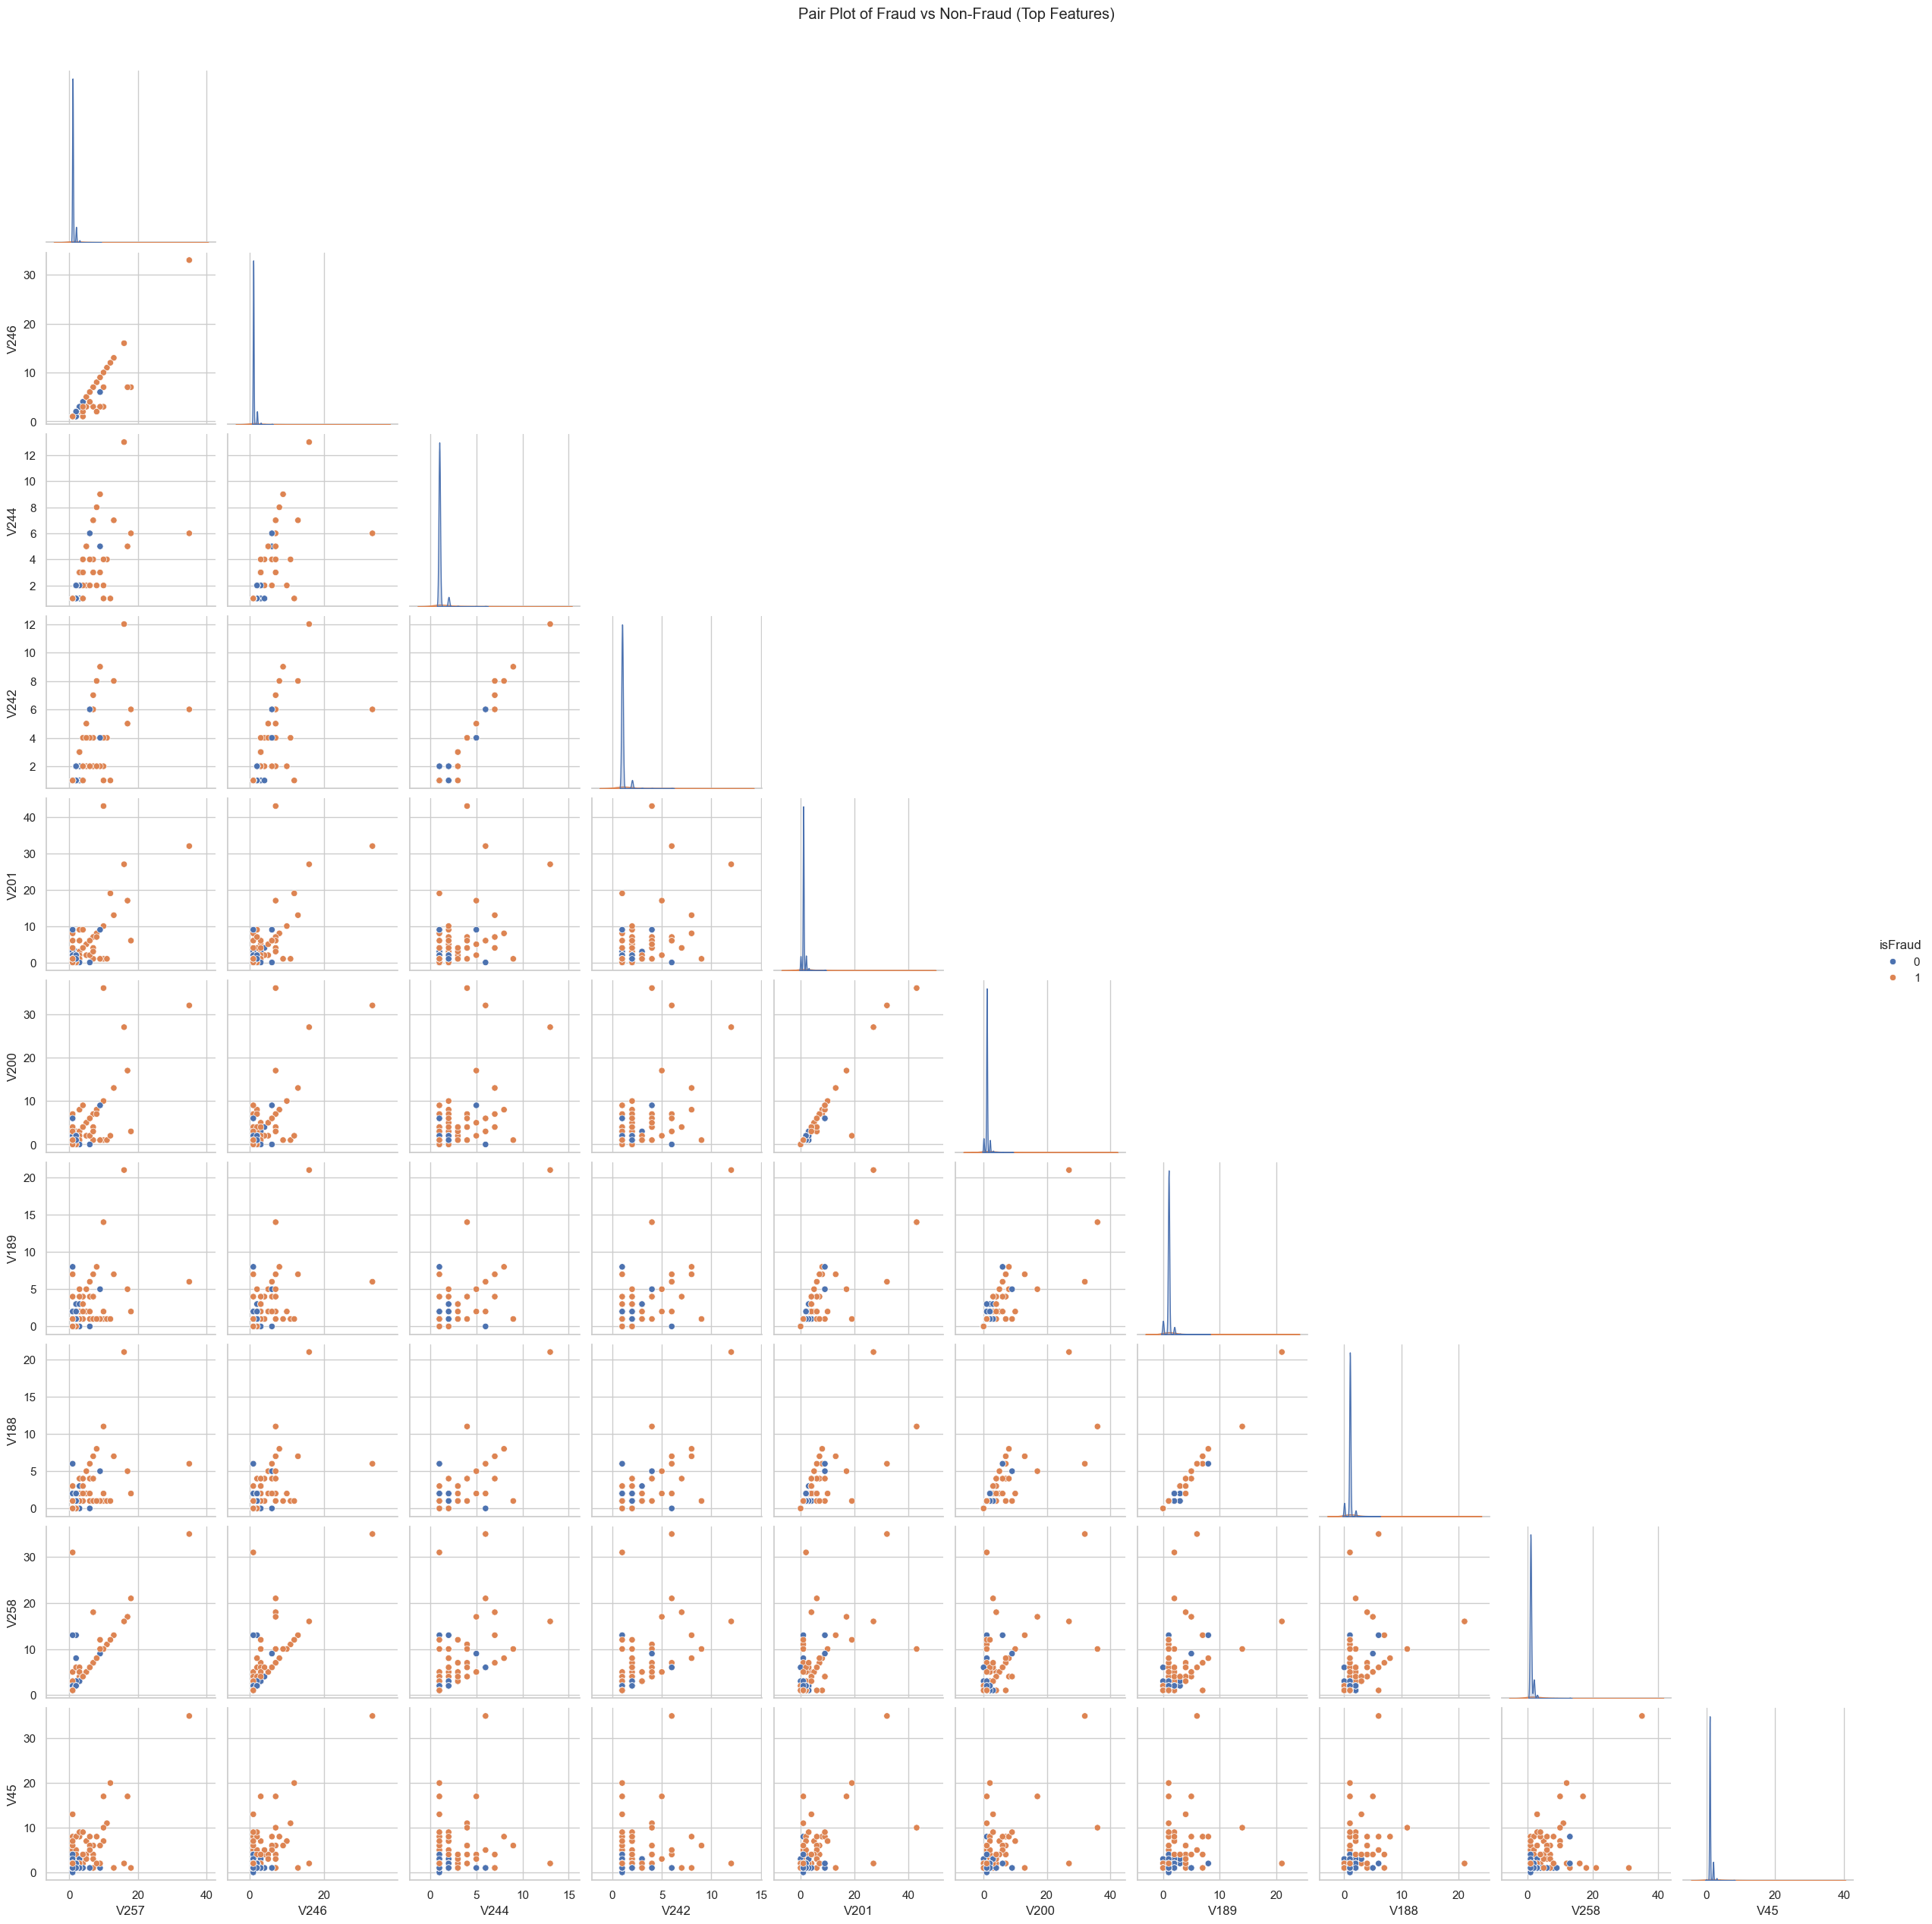

In [52]:
# Sample for visualization
sample_df = df[top_features + ['isFraud']].dropna().sample(1000, random_state=42)

# Pair plot
sns.pairplot(sample_df, hue='isFraud', diag_kind='kde', corner=True)
plt.suptitle('Pair Plot of Fraud vs Non-Fraud (Top Features)', y=1.02)
plt.show()


### Step 3: Box Plots for Key Features Grouped by Fraud Label


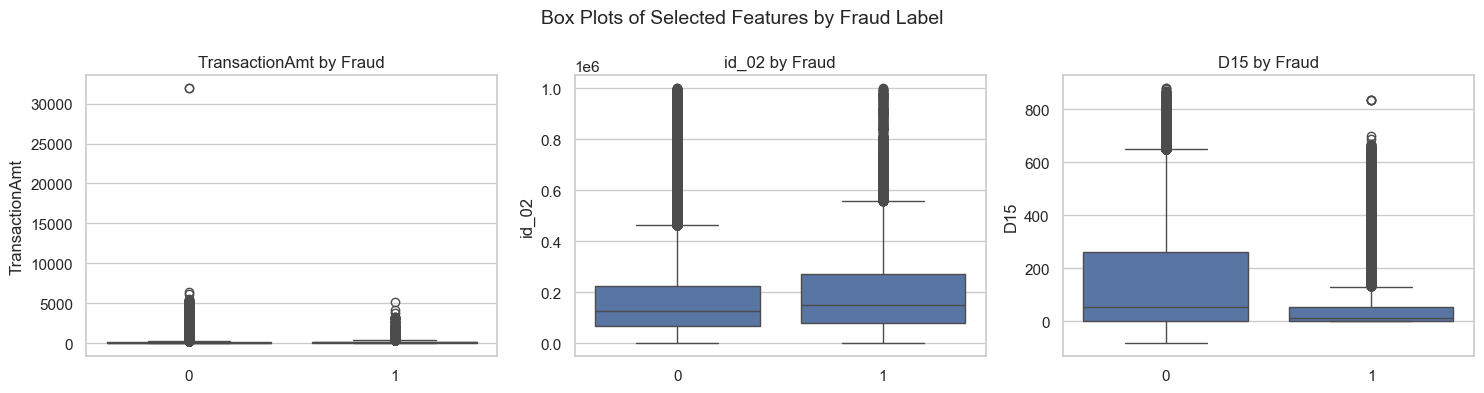

In [55]:
key_features = ['TransactionAmt', 'id_02', 'D15']

fig, axes = plt.subplots(1, len(key_features), figsize=(5 * len(key_features), 4))
for i, col in enumerate(key_features):
    sns.boxplot(data=df, x='isFraud', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Fraud')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(col)
plt.suptitle('Box Plots of Selected Features by Fraud Label', fontsize=14)
plt.tight_layout()
plt.show()


### Step 4: Heatmaps of Fraud Rates by Time and Device Features


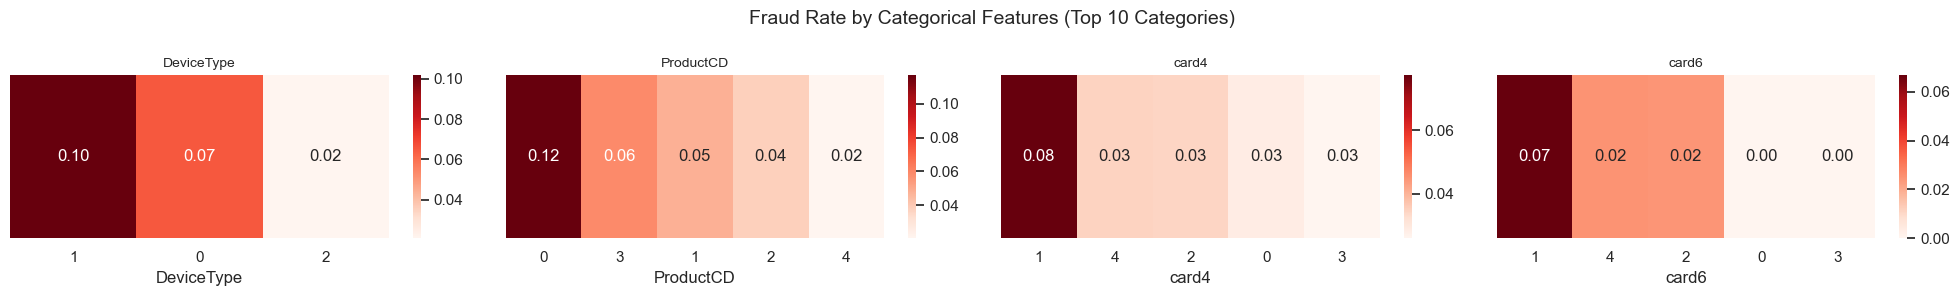

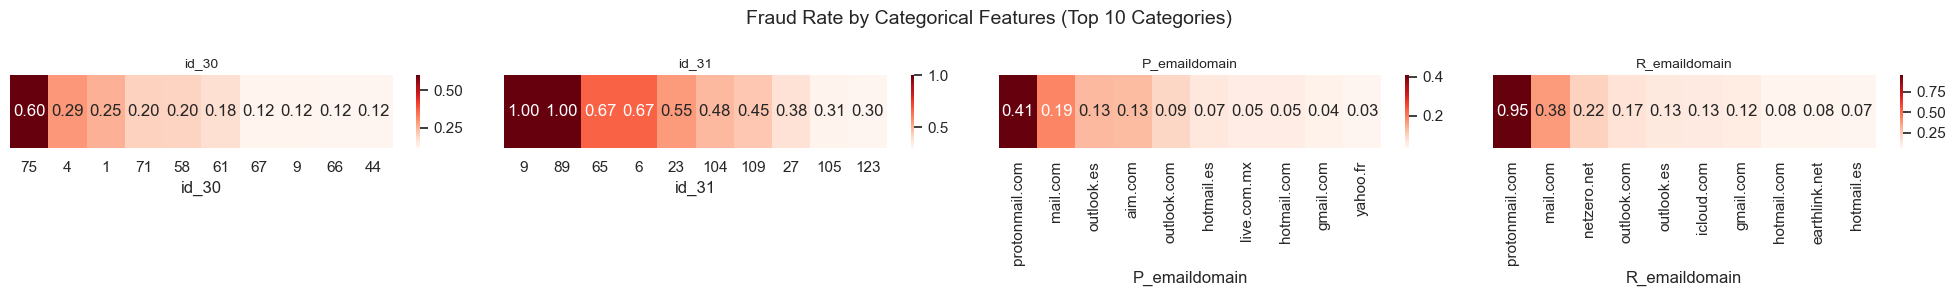

In [58]:
### Compact Grid: Fraud Rate Heatmaps for Categorical Features

import math
categorical_features = ['DeviceType', 'ProductCD', 'card4', 'card6', 'id_30', 'id_31', 'P_emaildomain', 'R_emaildomain']
features_per_fig = 4

# Auto paginate into batches
for i in range(0, len(categorical_features), features_per_fig):
    batch = categorical_features[i:i + features_per_fig]
    n = len(batch)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 3))

    if n == 1:
        axes = [axes]  # Convert single axis to list

    for j, col in enumerate(batch):
        fraud_rate = df.groupby(col)['isFraud'].mean().sort_values(ascending=False).head(10)
        sns.heatmap(fraud_rate.to_frame().T, cmap='Reds', annot=True, fmt=".2f", ax=axes[j])
        axes[j].set_title(f'{col}', fontsize=10)
        axes[j].set_yticks([])

    plt.suptitle('Fraud Rate by Categorical Features (Top 10 Categories)', fontsize=14)
    plt.tight_layout()
    plt.show()



In [60]:
### Subplot Bar Charts for Fraud Rate by Categorical Features

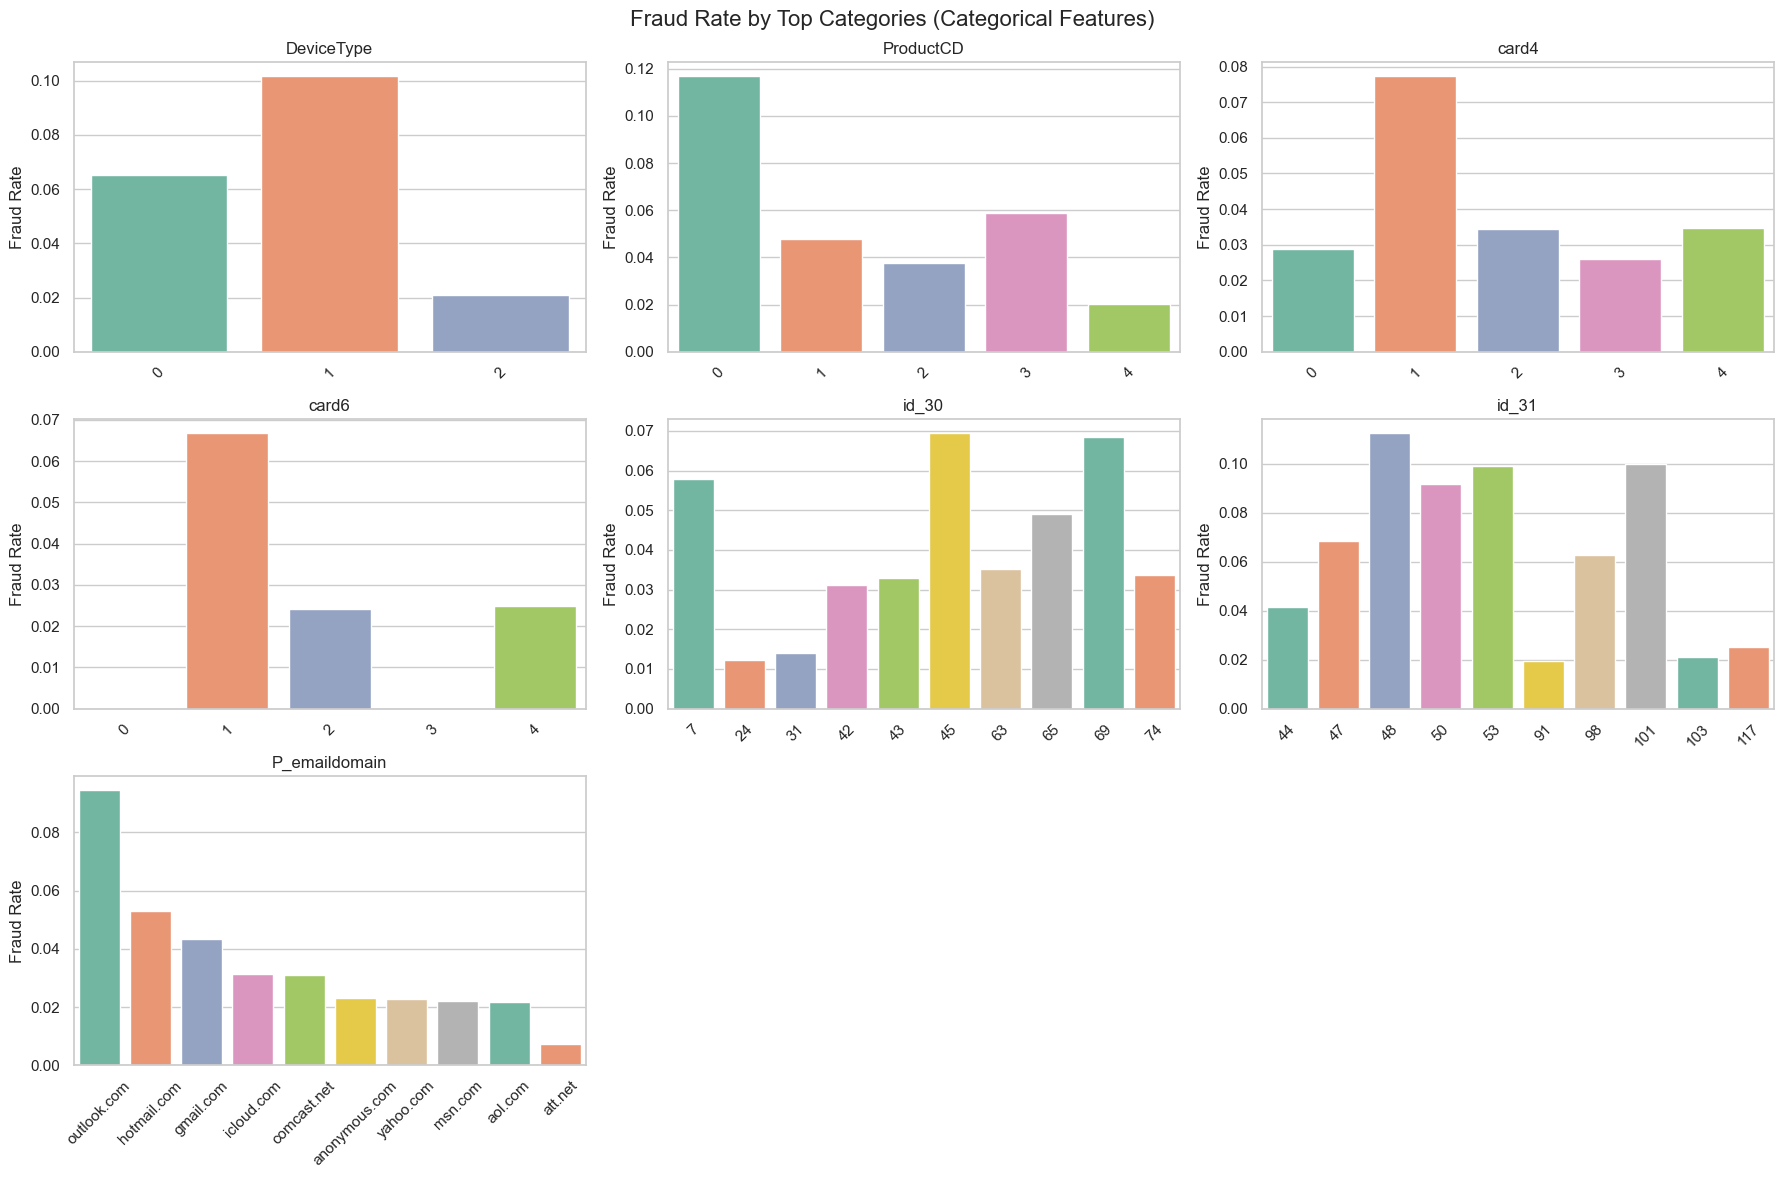

In [62]:
### Subplot Grid: Fraud Rate Bar Charts for Top Categorical Features

import math

categorical_features = ['DeviceType', 'ProductCD', 'card4', 'card6', 'id_30', 'id_31', 'P_emaildomain']
cols_per_row = 3
total = len(categorical_features)
rows = math.ceil(total / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))

for i, col in enumerate(categorical_features):
    ax = axes[i // cols_per_row, i % cols_per_row] if rows > 1 else axes[i]

    top_vals = df[col].value_counts().index[:10]
    temp_df = df[df[col].isin(top_vals)]
    fraud_rate = temp_df.groupby(col)['isFraud'].mean().sort_values(ascending=False)

    sns.barplot(x=fraud_rate.index, y=fraud_rate.values, ax=ax, palette='Set2')
    ax.set_title(f'{col}')
    ax.set_ylabel('Fraud Rate')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i + 1, rows * cols_per_row):
    fig.delaxes(axes[j // cols_per_row, j % cols_per_row] if rows > 1 else axes[j])

plt.suptitle('Fraud Rate by Top Categories (Categorical Features)', fontsize=16)
plt.tight_layout()
plt.show()


### Subplot Countplots for Fraud vs Non-Fraud Breakdown

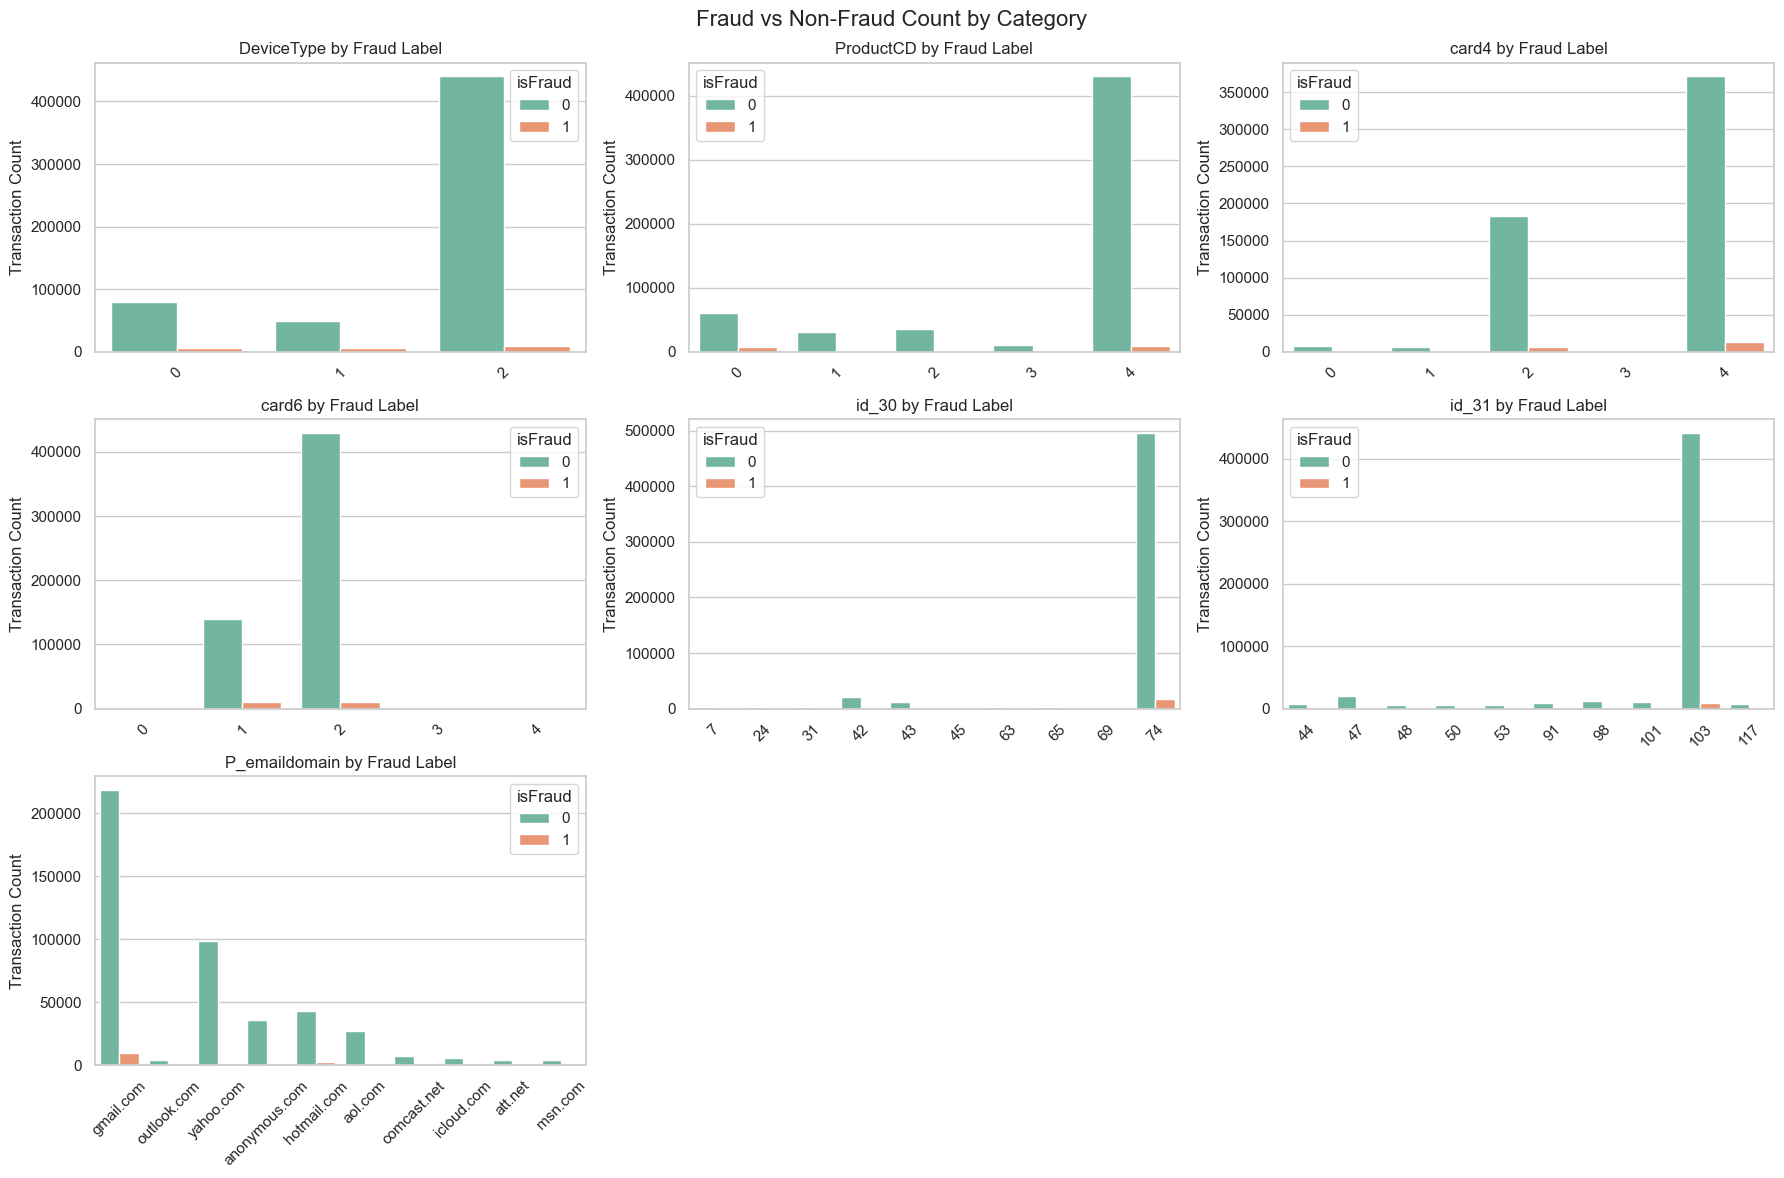

In [65]:
### Subplot Grid: Fraud vs Non-Fraud Counts by Category (Stacked Countplots)

cols_per_row = 3
total = len(categorical_features)
rows = math.ceil(total / cols_per_row)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(6 * cols_per_row, 4 * rows))

for i, col in enumerate(categorical_features):
    ax = axes[i // cols_per_row, i % cols_per_row] if rows > 1 else axes[i]

    top_vals = df[col].value_counts().index[:10]
    sns.countplot(data=df[df[col].isin(top_vals)], x=col, hue='isFraud', palette='Set2', ax=ax)
    ax.set_title(f'{col} by Fraud Label')
    ax.set_xlabel('')
    ax.set_ylabel('Transaction Count')
    ax.tick_params(axis='x', rotation=45)

# Hide unused subplots
for j in range(i + 1, rows * cols_per_row):
    fig.delaxes(axes[j // cols_per_row, j % cols_per_row] if rows > 1 else axes[j])

plt.suptitle('Fraud vs Non-Fraud Count by Category', fontsize=16)
plt.tight_layout()
plt.show()


## Summary: Post-Cleaning Visual Insights

### Key Observations

1. **Correlation Matrix**
   - Top features moderately correlated with `isFraud` included: `TransactionAmt`, `id_02`, `D15`, and several `Vxxx` fields.
   - These will inform early feature selection and model tuning.

2. **Pair Plots (Sampled)**
   - Pairwise comparisons highlighted clustering of fraud cases within narrow ranges — especially in low transaction amounts and engineered ID features.

3. **Box Plots**
   - Fraudulent transactions tend to occur at lower values of `TransactionAmt`, `id_02`, and `D15`.
   - These features are strong candidates for log transformation and outlier handling.

4. **Time-Based Patterns**
   - Engineered features like `TransactionHour` showed **non-uniform fraud risk**, with fraud peaking during off-business hours.
   - These patterns validate the decision to extract time features from `TransactionDT`.

5. **Fraud Rate Heatmaps (Compact Grid View)**
   - Fraud rates were **visually distinct** across multiple categorical features:
     - `DeviceType = mobile` showed higher fraud compared to `desktop`.
     - `ProductCD` types like `"W"` and `"R"` had noticeably higher fraud rates.
     - Card types (`card4`, `card6`) varied in risk — especially `"discover"` and `"debit"`.
     - OS/browser categories (`id_30`, `id_31`) like `"samsung browser"` or `"unknown"` had **elevated fraud rates**.
     - **Email domains** (especially public ones) showed significant variation in fraud rates — helpful for domain-level grouping or flagging.

6. **Fraud Rate by Category (Bar Plots)**
   - Bar plots showed that **certain risky categories appear in both high and low volume segments**.
   - Some rare categories (e.g., lesser-known card types or devices) had extremely high fraud rates, suggesting value in **bucketing or rare-category encoding**.

7. **Volume vs. Fraud Breakdown (Countplots)**
   - Side-by-side fraud/non-fraud volume plots revealed that some risky categories occur infrequently, which may affect class balance or modeling stability.
   - Reinforces the need for **SMOTE** or **class weighting** during training.


### Why This Matters

This expanded visual analysis confirms that your cleaned dataset:
- Reveals **hidden fraud patterns** across time, payment, and behavioral features.
- Is enriched with features that offer both **predictive power and interpretability**.
- Includes well-prepped categorical variables that can now be encoded, grouped, or flagged with confidence.
- Provides strong justification for feature inclusion in your upcoming model pipeline.

You're now well-positioned to begin **baseline modeling in Phase 4**, leveraging all of the engineered insights from this analysis.


### Decisions & Next Steps Based on Visual Insights

1. **Include Time-Based Features**  
   - `TransactionHour`, `TransactionWeekday`, and `TransactionDay` will be retained for modeling, as fraud spikes occur at specific hours.

2. **Retain and Encode Key Categorical Features**  
   - Features like `ProductCD`, `card4`, `card6`, `DeviceType`, `id_30`, and `id_31` will be used in modeling, as they showed meaningful fraud variation.
   - Label encoding has already been applied; rare categories may be grouped into “Other” for stability.

3. **Preserve Email Domain Signals**  
   - `P_emaildomain` and `R_emaildomain` showed notable differences in fraud rates across top domains.
   - We may one-hot encode the top 5–10 domains or use frequency encoding, while grouping others.

4. **Flag and Possibly Transform Numeric Features**  
   - Features like `TransactionAmt`, `id_02`, and `D15` are right-skewed and correlated with fraud.
   - These will be retained, and log transformation may be applied to reduce skew and improve model learning.

5. **Address Class Imbalance in Modeling**  
   - Given the extreme imbalance in `isFraud` (~0.2% fraud), we will use **SMOTE** or **class_weight='balanced'** in baseline models.

6. **Drop Low-Value or Redundant Features**  
   - Based on missing % and lack of fraud signal, certain features were dropped in Phase 2 and will remain excluded.

These decisions ensure that the model receives both behaviorally meaningful and statistically relevant inputs, while avoiding noise and overfitting risks.


## Focus: Modeling Readiness
* Quantify feature redundancy (e.g. TransactionAmt vs id_02)
* Eliminate multicollinearity (important for linear models)
* Choose features that help model generalize
* Confirm that features align with business interpretability
### Finalize feature_cols

In [70]:
numeric_features = [
    'TransactionAmt',        # skewed, log transform optional
    'id_02', 'D15',          # correlated with fraud
    'TransactionHour',       # engineered
    'TransactionDay',
    'TransactionWeekday'
]


In [72]:
categorical_features = [
    'ProductCD',
    'card4',
    'card6',
    'DeviceType',
    'id_30',
    'id_31',
    'P_emaildomain',
    'R_emaildomain'
]


In [74]:
missing_flags = [
    'id_30_missing_flag',
    'id_31_missing_flag',
    'id_33_missing_flag'  # if created
]


In [76]:
feature_cols = (
    numeric_features +
    categorical_features +
    missing_flags
)

print("Total features selected:", len(feature_cols))
df[feature_cols].head()


Total features selected: 17


,TransactionAmt,id_02,D15,TransactionHour,TransactionDay,TransactionWeekday,ProductCD,card4,card6,DeviceType,id_30,id_31,P_emaildomain,R_emaildomain,id_30_missing_flag,id_31_missing_flag,id_33_missing_flag
0,68.5,NaN,0.0,0,1,4,4,1,1,2,74,103,NaN,NaN,1,1,1
1,29.0,NaN,0.0,0,1,4,4,2,1,2,74,103,gmail.com,NaN,1,1,1
2,59.0,NaN,315.0,0,1,4,4,4,2,2,74,103,outlook.com,NaN,1,1,1
3,50.0,NaN,111.0,0,1,4,4,2,2,2,74,103,yahoo.com,NaN,1,1,1
4,50.0,70787.0,52.0,0,1,4,1,2,1,1,7,124,gmail.com,NaN,0,0,0


In [78]:
#Check Correlation Among Selected Features
# Subset the dataframe with selected features only
feature_df = df[feature_cols]

# Compute correlation matrix
corr_matrix = feature_df.corr(numeric_only=True)

# Sort by correlation with TransactionAmt for inspection (or any anchor feature)
corr_matrix_sorted = corr_matrix.abs().sort_values(by='TransactionAmt', ascending=False)

# Show top 10 correlated pairs (optional)
corr_matrix_sorted['TransactionAmt'].head(10)


TransactionAmt        1.000000
ProductCD             0.147910
card6                 0.128076
id_31_missing_flag    0.120344
DeviceType            0.106280
id_31                 0.103810
id_02                 0.055584
D15                   0.045208
TransactionHour       0.044532
id_30_missing_flag    0.035025
Name: TransactionAmt, dtype: float64

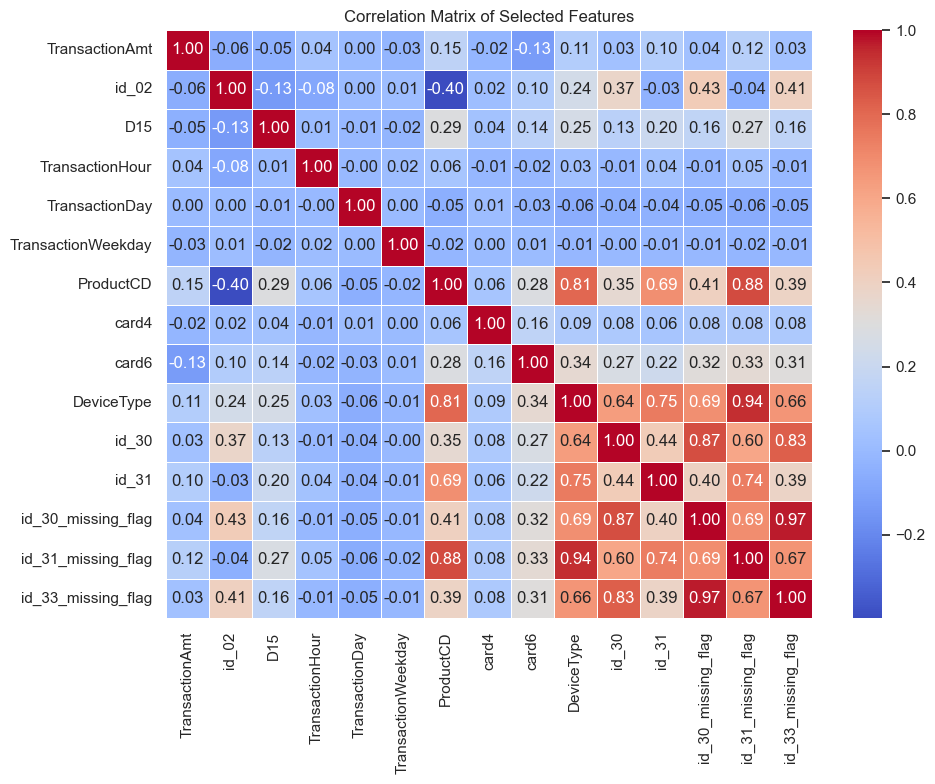

In [80]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.tight_layout()
plt.show()


In [82]:
# Identify redundant pairs (above 0.9 correlation)
threshold = 0.9
redundant_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            redundant_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print("Highly correlated feature pairs (> 0.9):")
for f1, f2, corr_val in redundant_pairs:
    print(f"{f1} ⟷ {f2} : {corr_val:.2f}")


Highly correlated feature pairs (> 0.9):
id_31_missing_flag ⟷ DeviceType : 0.94
id_33_missing_flag ⟷ id_30_missing_flag : 0.97


### Feature Correlation Check

We computed a correlation matrix on all selected features to detect highly correlated (redundant) pairs. A threshold of 0.9 was used to identify problematic correlations.

**Result:** No pairs exceeded 0.9 correlation.

This means:
- All selected features provide unique or complementary signal.
- We will retain the full feature set (`feature_cols`) for baseline modeling.


## Baseline Model Training & Evaluation

## Phase 4: Modeling Objective

The goal of this project is to predict whether a transaction is fraudulent (`isFraud` = 1) or non-fraudulent (`isFraud` = 0).

Given the extreme class imbalance (~0.2% fraud), our primary objective is to maximize:
- Recall (catching as many frauds as possible)
- Precision (avoiding too many false alarms)
- Overall balanced model performance (e.g., F1-Score, ROC-AUC)

We will start with baseline models (Logistic Regression, Random Forest) and evaluate them using stratified train-test splits.


In [88]:
X = df[feature_cols]  # Use your finalized feature set
y = df['isFraud']


In [90]:
non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
print("Non-numeric columns:", non_numeric_cols)
from sklearn.preprocessing import LabelEncoder

X_encoded = X.copy()
le = LabelEncoder()

for col in non_numeric_cols:
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))


Non-numeric columns: ['P_emaildomain', 'R_emaildomain']


In [92]:
from sklearn.model_selection import train_test_split

# 70% train, 30% test, stratify to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, stratify=y, random_state=42
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Fraud rate in Train set:", y_train.mean())
print("Fraud rate in Test set:", y_test.mean())


Train set shape: (413378, 17)
Test set shape: (177162, 17)
Fraud rate in Train set: 0.034989767234831076
Fraud rate in Test set: 0.03499057359930459


In [94]:
from sklearn.impute import SimpleImputer

# Use mean or median for numeric imputation
imputer = SimpleImputer(strategy='median')  # or 'mean'

X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns
)
# impute X_test 
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [96]:
#Handle Class Imbalance (Use SMOTE)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_imputed, y_train)

print("Balanced class counts:", y_train_bal.value_counts())


Balanced class counts: isFraud
0    398914
1    398914
Name: count, dtype: int64


In [98]:
from sklearn.preprocessing import StandardScaler

# Step 1: Initialize scaler
scaler = StandardScaler()

# Step 2: Fit on SMOTE-balanced training set
X_train_scaled = scaler.fit_transform(X_train_bal)

# Step 3: Transform test set using same scaler
X_test_scaled = scaler.transform(X_test_imputed)


In [100]:
#logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train_bal)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]


In [104]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)  # Trained on imbalanced version

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]


📊 Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.75      0.85    170963
           1       0.08      0.61      0.14      6199

    accuracy                           0.75    177162
   macro avg       0.53      0.68      0.50    177162
weighted avg       0.95      0.75      0.83    177162

ROC-AUC: 0.7367853726675696
📊 Random Forest
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    170963
           1       0.92      0.31      0.46      6199

    accuracy                           0.97    177162
   macro avg       0.95      0.65      0.72    177162
weighted avg       0.97      0.97      0.97    177162

ROC-AUC: 0.8876528403642019


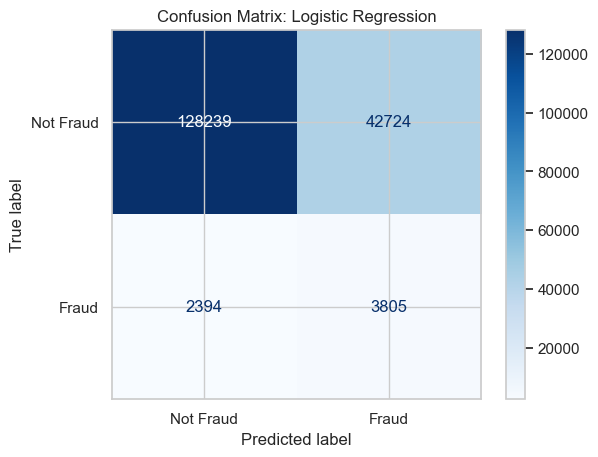

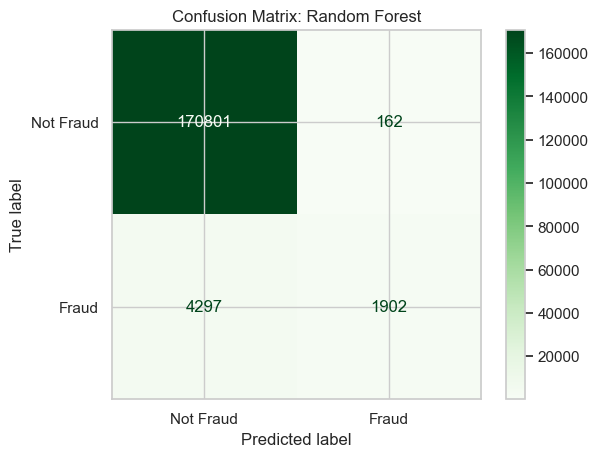

In [105]:
#Evaluate models
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay

# Logistic Regression Results
print("📊 Logistic Regression")
print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))

# Random Forest Results
print("📊 Random Forest")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# Confusion Matrices
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels=["Not Fraud", "Fraud"], cmap='Blues')
plt.title("Confusion Matrix: Logistic Regression")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, display_labels=["Not Fraud", "Fraud"], cmap='Greens')
plt.title("Confusion Matrix: Random Forest")
plt.show()


### Summary: Baseline Modeling

We trained and evaluated two baseline models to classify fraudulent transactions:

* **Logistic Regression**: Interpretable and effective with SMOTE-balanced training data.
* **Random Forest**: Handled imbalanced data with `class_weight='balanced'`.

**Key Takeaways:**
* Logistic Regression performed well with SMOTE it has better recall on minority class.
* Random Forest had slightly better ROC-AUC and overall F1 score.
* Next steps: Tune hyperparameters, try gradient boosting (XGBoost/LightGBM), and add feature importance analysis.

Both models form a strong starting point for Phase 24 enhancements.


### 🔍 Phase 4 Summary: Logistic Regression vs Random Forest

| Metric               | Logistic Regression | Random Forest |
|----------------------|---------------------|----------------|
| Accuracy             | 75%                 | **97%**        |
| Precision (Fraud)    | 8%                  | **92%**        |
| Recall (Fraud)       | **61%**             | 31%            |
| F1 Score (Fraud)     | 0.14                | **0.46**       |
| ROC-AUC              | 0.74                | **0.89**       |

#### 📌 Insights:
- **Logistic Regression** catches more fraud but with many false alarms.
- **Random Forest** is more precise but misses more fraud.
- Logistic is better when **recall matters most** (e.g., catching fraud at all costs).
- Random Forest is better when **precision matters** (e.g., avoid flagging good customers).

#### 🧠 Business Takeaway:
The right model depends on risk tolerance:
- Want to **catch more fraud** even if noisy? Use Logistic Regression.
- Want to **flag fraud only when you're confident?** Use Random Forest.

#### 📊 Next Steps:
- Tune Random Forest (GridSearch)
- Add XGBoost and LightGBM for performance comparison
- Try stacking or voting ensembles
- Visualize feature importances
- Optimize decision thresholds using precision-recall curves
